In this project, randomly chosen 574 restaurants will be scored according to their user rates and number of voters. Then they will be segmented using k-means.


The restaurant data were scraped from Restaurantguru.com where the rates and number of voters from various sites are kept. The related code is in the project web_scraping.py. The columns ending with '_rg' were extracted. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


In [3]:
dataset = pd.read_csv(r"C:\Users\PC\Documents\places_final.csv")

In [4]:
dataset.head()

,place_name,city,town,address,name_rg,price_check_rg,rank_rg,rating_rg,price_rg,address_rg,features_rg,website_rg,instagram_rg,cuisine_rg,yelp_rg,trip_rg,google_rate,google_total,checkpoint
0,11 Kadıköy,İstanbul,Kadıköy,CAFERAĞA MAH ARAYICI BAŞI SOK NO 11 A-1 KADIKO...,11 Kadıköy,No-Info,#221 of 72430 restaurants in Istanbul,Ratings of 11 Kadıköy\nZomato\n4.6 / 5\n1097\n...,$$$$ Price range per person TRY 170 - TRY 410,"Address\nKadıköy\nArayıcıbaşı Sk. No:11, Istan...",Features\nСredit cards accepted\nOutdoor seati...,No-Info,@11kadikoy,Cocktail bars,No-Info,No-Info,4.4,437,True
1,3g pub,İzmir,Konak,CUMHURİYET BULVARI NO:18 KONAK IZMIR,3G Cafe,Expensive (average price TRY 410 - TRY 830),#1732 of 12479 cafes in Izmir,Ratings of 3G Cafe\nYelp\nNot rated yet\nFours...,$$$$ Price range per person TRY 410 - TRY 830,Address\nÇankaya\nKonak Mahallesi İzmirlioğlu ...,Features\nСredit cards accepted\nOutdoor seati...,No-Info,No-Info,No-Info,no_rating,No-Info,3.5,21,True
2,45 Bar Kadikoy,İstanbul,Kadıköy,İSTANBUL KADIKÖY KADIKOY ISTANBUL,45 Bar Kadikoy,No-Info,#1309 of 11620 pubs & bars in Istanbul,Ratings of 45 Bar Kadikoy\nZomato\n2.4 / 5\n83...,$$$$ Price range per person TRY 170 - TRY 410,"Address\nKadıköy\nMiralay Nazım Sk. No:19/A, I...",Features\nСredit cards accepted\nWi-Fi\nBookin...,Website\n45likkadikoy.com,@45likcomtr,No-Info,No-Info,No-Info,3.7,565,True
3,6:45 Losers Club,İzmir,Konak,1482 SOKAK NO:10 KONAK IZMIR,6:45 Losers Club,Moderate (average price TRY 170 - TRY 410),#47 of 599 clubs in Izmir,Ratings of 6:45 Losers Club\nGoogle\n955,$$$$ Price range per person TRY 170 - TRY 410,"Address\nÇankaya\nMuzaffer İzgü Sk. No:10, Izm...",Features\nNo delivery\nOutdoor seating\nNo tak...,No-Info,No-Info,No-Info,No-Info,No-Info,4.1,1011,True
4,Adabeyi Balık Restoran,İzmir,Konak,ATATÜRK Cd.AKDENİZ Mh. No:19/d,Adabeyi Balık Restoran,Expensive (average price TRY 410 - TRY 830),#320 of 18291 restaurants in Izmir,Ratings of Adabeyi Balık Restoran\nYelp\n5\nZo...,$$$$ Price range per person TRY 410 - TRY 830,Address\nÇankaya\nKonak Atatürk Cad. Konak Pie...,Features\nСredit cards accepted\nOutdoor seati...,No-Info,No-Info,"Seafood, Turkish",yelp_block stars5,fill rate4_5,4.2,819,True


In [5]:
# rating_rg column should be arranged to split and hence get the scores.

dataset["rating_rg_split"] = dataset["rating_rg"].str.replace("\n", " ")

dataset["yelp_rate"] = 0.0
dataset["yelp_total"] = 0

dataset["zomato_rate"] = 0.0
dataset["zomato_total"] = 0

dataset["foursquare_rate"] = 0.0
dataset["foursquare_total"] = 0

dataset["trip_rate"] = 0.0
dataset["trip_total"] = 0

dataset["facebook_rate"] = 0.0
dataset["facebook_total"] = 0

for i in range(len(dataset)):
    a  =dataset.loc[i]["rating_rg_split"]
    alist = a.replace("/ ","").split(" ")
        
    # YELP
    try:
        index_yelp = alist.index("Yelp")
        if alist[index_yelp +1] == "Not":
            dataset.loc[i,"yelp_total"] = np.nan
        else:
            dataset.loc[i,"yelp_total"] = alist[index_yelp +1]
    except ValueError:
        dataset.loc[i,"yelp_total"] = np.nan
        
    if dataset.loc[i,"yelp_rg"] == "No-Info" or dataset.loc[i,"yelp_rg"] == "no_rating":
        dataset.loc[i,"yelp_rate"] = np.nan
    else:
        dataset.loc[i,"yelp_rate"] = float(dataset.loc[i,"yelp_rg"][16:].replace("_","."))
        

    # ZOMATO
    try:
        index_zomato = alist.index("Zomato")
        if alist[index_zomato +1] == "Not":
            dataset.loc[i,"zomato_rate"] = np.nan
            dataset.loc[i,"zomato_total"] = np.nan
        else:
            dataset.loc[i,"zomato_rate"] = float(alist[index_zomato +1])
            dataset.loc[i,"zomato_total"] = int(alist[index_zomato +3])
    except ValueError:
        dataset.loc[i,"zomato_rate"] = np.nan
        dataset.loc[i,"zomato_total"] = np.nan
    
    # FOURSQUARE
    try:
        index_fs = alist.index("Foursquare")
        if alist[index_fs +1] == "Not":
            dataset.loc[i,"foursquare_rate"] = np.nan
            dataset.loc[i,"foursquare_total"] = np.nan
        else:
            dataset.loc[i,"foursquare_rate"] = float(alist[index_fs +1])
            dataset.loc[i,"foursquare_total"] = int(alist[index_fs +3])
    except ValueError:
        dataset.loc[i,"foursquare_rate"] = np.nan
        dataset.loc[i,"foursquare_total"] = np.nan
    
    # TRIP
    try:
        index_trip = alist.index("Trip")
        if alist[index_trip +1] == "Not":
            dataset.loc[i,"trip_total"] = np.nan
        else:
            dataset.loc[i,"trip_total"] = int(alist[index_trip +1])
    except ValueError:
        dataset.loc[i,"trip_total"] = np.nan 
        
    if dataset.loc[i,"trip_rg"] == "No-Info" or dataset.loc[i]["trip_rg"] == "no_rating":
        dataset.loc[i,"trip_rate"] = np.nan
    else:
        dataset.loc[i,"trip_rate"] = float(dataset.loc[i,"trip_rg"][9:].replace("_","."))

    # FACEBOOK
    try:
        index_fb = alist.index("Facebook")
        if alist[index_fb +1] == "Not":
            dataset.loc[i,"facebook_rate"] = np.nan
            dataset.loc[i,"facebook_total"] = np.nan
        else:
            dataset.loc[i,"facebook_rate"] = float(alist[index_fb +1])
            dataset.loc[i,"facebook_total"] = int(alist[index_fb +2])
    except ValueError:
        dataset.loc[i,"facebook_rate"] = np.nan
        dataset.loc[i,"facebook_total"] = np.nan
    except IndexError:
        dataset.loc[i,"facebook_rate"] = np.nan
        dataset.loc[i,"facebook_total"] = np.nan

In [6]:
dataset.head()

,place_name,city,town,address,name_rg,price_check_rg,rank_rg,rating_rg,price_rg,address_rg,features_rg,website_rg,instagram_rg,cuisine_rg,yelp_rg,trip_rg,google_rate,google_total,checkpoint,rating_rg_split,yelp_rate,yelp_total,zomato_rate,zomato_total,foursquare_rate,foursquare_total,trip_rate,trip_total,facebook_rate,facebook_total
0,11 Kadıköy,İstanbul,Kadıköy,CAFERAĞA MAH ARAYICI BAŞI SOK NO 11 A-1 KADIKO...,11 Kadıköy,No-Info,#221 of 72430 restaurants in Istanbul,Ratings of 11 Kadıköy\nZomato\n4.6 / 5\n1097\n...,$$$$ Price range per person TRY 170 - TRY 410,"Address\nKadıköy\nArayıcıbaşı Sk. No:11, Istan...",Features\nСredit cards accepted\nOutdoor seati...,No-Info,@11kadikoy,Cocktail bars,No-Info,No-Info,4.4,437,True,Ratings of 11 Kadıköy Zomato 4.6 / 5 1097 Four...,NaN,NaN,4.6,1097.0,8.8,63.0,NaN,NaN,NaN,NaN
1,3g pub,İzmir,Konak,CUMHURİYET BULVARI NO:18 KONAK IZMIR,3G Cafe,Expensive (average price TRY 410 - TRY 830),#1732 of 12479 cafes in Izmir,Ratings of 3G Cafe\nYelp\nNot rated yet\nFours...,$$$$ Price range per person TRY 410 - TRY 830,Address\nÇankaya\nKonak Mahallesi İzmirlioğlu ...,Features\nСredit cards accepted\nOutdoor seati...,No-Info,No-Info,No-Info,no_rating,No-Info,3.5,21,True,Ratings of 3G Cafe Yelp Not rated yet Foursqua...,NaN,NaN,NaN,NaN,6.7,59.0,NaN,NaN,NaN,NaN
2,45 Bar Kadikoy,İstanbul,Kadıköy,İSTANBUL KADIKÖY KADIKOY ISTANBUL,45 Bar Kadikoy,No-Info,#1309 of 11620 pubs & bars in Istanbul,Ratings of 45 Bar Kadikoy\nZomato\n2.4 / 5\n83...,$$$$ Price range per person TRY 170 - TRY 410,"Address\nKadıköy\nMiralay Nazım Sk. No:19/A, I...",Features\nСredit cards accepted\nWi-Fi\nBookin...,Website\n45likkadikoy.com,@45likcomtr,No-Info,No-Info,No-Info,3.7,565,True,Ratings of 45 Bar Kadikoy Zomato 2.4 / 5 83 Fo...,NaN,NaN,2.4,83.0,5.5,364.0,NaN,NaN,1.0,1.0
3,6:45 Losers Club,İzmir,Konak,1482 SOKAK NO:10 KONAK IZMIR,6:45 Losers Club,Moderate (average price TRY 170 - TRY 410),#47 of 599 clubs in Izmir,Ratings of 6:45 Losers Club\nGoogle\n955,$$$$ Price range per person TRY 170 - TRY 410,"Address\nÇankaya\nMuzaffer İzgü Sk. No:10, Izm...",Features\nNo delivery\nOutdoor seating\nNo tak...,No-Info,No-Info,No-Info,No-Info,No-Info,4.1,1011,True,Ratings of 6:45 Losers Club Google 955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adabeyi Balık Restoran,İzmir,Konak,ATATÜRK Cd.AKDENİZ Mh. No:19/d,Adabeyi Balık Restoran,Expensive (average price TRY 410 - TRY 830),#320 of 18291 restaurants in Izmir,Ratings of Adabeyi Balık Restoran\nYelp\n5\nZo...,$$$$ Price range per person TRY 410 - TRY 830,Address\nÇankaya\nKonak Atatürk Cad. Konak Pie...,Features\nСredit cards accepted\nOutdoor seati...,No-Info,No-Info,"Seafood, Turkish",yelp_block stars5,fill rate4_5,4.2,819,True,Ratings of Adabeyi Balık Restoran Yelp 5 Zomat...,5.0,5,3.8,48.0,8.1,899.0,4.5,127.0,4.2,539.0


In [7]:
dataset.dtypes

place_name           object
city                 object
town                 object
address              object
name_rg              object
price_check_rg       object
rank_rg              object
rating_rg            object
price_rg             object
address_rg           object
features_rg          object
website_rg           object
instagram_rg         object
cuisine_rg           object
yelp_rg              object
trip_rg              object
google_rate         float64
google_total          int64
checkpoint             bool
rating_rg_split      object
yelp_rate           float64
yelp_total           object
zomato_rate         float64
zomato_total        float64
foursquare_rate     float64
foursquare_total    float64
trip_rate           float64
trip_total          float64
facebook_rate       float64
facebook_total      float64
dtype: object

In [8]:
dataset["yelp_total"] = dataset["yelp_total"].astype(float)

In [9]:
score_columns = ["google_rate", "google_total","yelp_rate", "yelp_total", "zomato_rate", "zomato_total", "foursquare_rate", "foursquare_total", "trip_rate", "trip_total", "facebook_rate", "facebook_total"]
dataset[score_columns] = dataset[score_columns].replace(np.nan, 0)

In [10]:
dataset.head()

,place_name,city,town,address,name_rg,price_check_rg,rank_rg,rating_rg,price_rg,address_rg,features_rg,website_rg,instagram_rg,cuisine_rg,yelp_rg,trip_rg,google_rate,google_total,checkpoint,rating_rg_split,yelp_rate,yelp_total,zomato_rate,zomato_total,foursquare_rate,foursquare_total,trip_rate,trip_total,facebook_rate,facebook_total
0,11 Kadıköy,İstanbul,Kadıköy,CAFERAĞA MAH ARAYICI BAŞI SOK NO 11 A-1 KADIKO...,11 Kadıköy,No-Info,#221 of 72430 restaurants in Istanbul,Ratings of 11 Kadıköy\nZomato\n4.6 / 5\n1097\n...,$$$$ Price range per person TRY 170 - TRY 410,"Address\nKadıköy\nArayıcıbaşı Sk. No:11, Istan...",Features\nСredit cards accepted\nOutdoor seati...,No-Info,@11kadikoy,Cocktail bars,No-Info,No-Info,4.4,437,True,Ratings of 11 Kadıköy Zomato 4.6 / 5 1097 Four...,0.0,0.0,4.6,1097.0,8.8,63.0,0.0,0.0,0.0,0.0
1,3g pub,İzmir,Konak,CUMHURİYET BULVARI NO:18 KONAK IZMIR,3G Cafe,Expensive (average price TRY 410 - TRY 830),#1732 of 12479 cafes in Izmir,Ratings of 3G Cafe\nYelp\nNot rated yet\nFours...,$$$$ Price range per person TRY 410 - TRY 830,Address\nÇankaya\nKonak Mahallesi İzmirlioğlu ...,Features\nСredit cards accepted\nOutdoor seati...,No-Info,No-Info,No-Info,no_rating,No-Info,3.5,21,True,Ratings of 3G Cafe Yelp Not rated yet Foursqua...,0.0,0.0,0.0,0.0,6.7,59.0,0.0,0.0,0.0,0.0
2,45 Bar Kadikoy,İstanbul,Kadıköy,İSTANBUL KADIKÖY KADIKOY ISTANBUL,45 Bar Kadikoy,No-Info,#1309 of 11620 pubs & bars in Istanbul,Ratings of 45 Bar Kadikoy\nZomato\n2.4 / 5\n83...,$$$$ Price range per person TRY 170 - TRY 410,"Address\nKadıköy\nMiralay Nazım Sk. No:19/A, I...",Features\nСredit cards accepted\nWi-Fi\nBookin...,Website\n45likkadikoy.com,@45likcomtr,No-Info,No-Info,No-Info,3.7,565,True,Ratings of 45 Bar Kadikoy Zomato 2.4 / 5 83 Fo...,0.0,0.0,2.4,83.0,5.5,364.0,0.0,0.0,1.0,1.0
3,6:45 Losers Club,İzmir,Konak,1482 SOKAK NO:10 KONAK IZMIR,6:45 Losers Club,Moderate (average price TRY 170 - TRY 410),#47 of 599 clubs in Izmir,Ratings of 6:45 Losers Club\nGoogle\n955,$$$$ Price range per person TRY 170 - TRY 410,"Address\nÇankaya\nMuzaffer İzgü Sk. No:10, Izm...",Features\nNo delivery\nOutdoor seating\nNo tak...,No-Info,No-Info,No-Info,No-Info,No-Info,4.1,1011,True,Ratings of 6:45 Losers Club Google 955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Adabeyi Balık Restoran,İzmir,Konak,ATATÜRK Cd.AKDENİZ Mh. No:19/d,Adabeyi Balık Restoran,Expensive (average price TRY 410 - TRY 830),#320 of 18291 restaurants in Izmir,Ratings of Adabeyi Balık Restoran\nYelp\n5\nZo...,$$$$ Price range per person TRY 410 - TRY 830,Address\nÇankaya\nKonak Atatürk Cad. Konak Pie...,Features\nСredit cards accepted\nOutdoor seati...,No-Info,No-Info,"Seafood, Turkish",yelp_block stars5,fill rate4_5,4.2,819,True,Ratings of Adabeyi Balık Restoran Yelp 5 Zomat...,5.0,5.0,3.8,48.0,8.1,899.0,4.5,127.0,4.2,539.0


In [11]:
dataset["total_score"] = (dataset["yelp_rate"] * dataset["yelp_total"]) + (dataset["zomato_rate"] * dataset["zomato_total"])+((dataset["foursquare_rate"] /2) * dataset["foursquare_total"] ) +  (dataset["trip_rate"] * dataset["trip_total"])+  (dataset["facebook_rate"] * dataset["facebook_total"]) 
dataset["google_score"] = dataset["google_rate"] * dataset["google_total"]

In [12]:
dataset.sort_values("total_score", ascending=False).head()

,place_name,city,town,address,name_rg,price_check_rg,rank_rg,rating_rg,price_rg,address_rg,features_rg,website_rg,instagram_rg,cuisine_rg,yelp_rg,trip_rg,google_rate,google_total,checkpoint,rating_rg_split,yelp_rate,yelp_total,zomato_rate,zomato_total,foursquare_rate,foursquare_total,trip_rate,trip_total,facebook_rate,facebook_total,total_score,google_score
367,Tavacı Recep Usta Alsancak - İzmir,İzmir,Konak,ATATÜRK CAD.NO:364 KONAK IZMIR,Tavacı Recep Usta Alsancak - İzmir,No-Info,#134 of 18291 restaurants in Izmir,Ratings of Tavacı Recep Usta Alsancak - İzmir\...,$$$$ Price range per person TRY 410 - TRY 830,"Address\nAtatürk Cd. No:364, Izmir, İzmir, Turkey",Features\nСredit cards accepted\nOutdoor seati...,Website\ntavacirecepusta.com,@trecepusta,"Turkish, Steakhouses",yelp_block stars4_5,fill rate4,4.2,5909,True,Ratings of Tavacı Recep Usta Alsancak - İzmir ...,4.5,15.0,4.1,269.0,8.9,8724.0,4.0,1496.0,0.0,0.0,45976.2,24817.8
264,My Chef,İstanbul,Kadıköy,BAHARİYE CADDESİ SAKIZGÜLÜ SK. NO.24/B/6 KADIK...,My Chef,No-Info,#318 of 46429 cafes in Istanbul,Ratings of My Chef\nYelp\n18\nZomato\n4.3 / 5\...,$$$$ Price range per person TRY 170 - TRY 410,"Address\nKadıköy\nSakız Gülü Sk. No:24, Istanb...",Features\nСredit cards accepted\nOutdoor seati...,Website\nmy-chef.com.tr,@mychefcafe,"European, Vegetarian options",yelp_block stars3_5,fill rate4,4.3,2427,True,Ratings of My Chef Yelp 18 Zomato 4.3 / 5 1402...,3.5,18.0,4.3,1402.0,8.4,7744.0,4.0,81.0,5.0,2.0,38950.4,10436.1
396,Viktor Levi Şarap Evi,İstanbul,Kadıköy,Caferağa Mah. Damacı Sok. No.4/A Kadıköy/İSTANBUL,Viktor Levi Şarap Evi,Moderate (average price TRY 250 - TRY 330),#1783 of 72430 restaurants in Istanbul,Ratings of Viktor Levi Şarap Evi\nYelp\n24\nZo...,$$$$ Price range per person TRY 250 - TRY 330,"Address\nKadıköy\nCaferağa Mh Moda Cd. &, Dama...",Features\nСredit cards accepted\nOutdoor seati...,Website\nviktorlevimoda.com,@viktorlevimoda,"Wine bars, Fast food, Seafood, Vegetarian options",yelp_block stars3_5,fill rate4,4.5,3942,True,Ratings of Viktor Levi Şarap Evi Yelp 24 Zomat...,3.5,24.0,4.4,1527.0,9.0,6327.0,4.0,265.0,4.0,4.0,36350.3,17739.0
116,Dorock XL Kadıköy,İstanbul,Kadıköy,CAFERAĞA MAH DUMLUPINAR SOK NO 21/A,Dorock XL Kadıköy,Moderate (average price TRY 170 - TRY 410),#583 of 46429 cafes in Istanbul,Ratings of Dorock XL Kadıköy\nYelp\n22\nZomato...,$$$$ Price range per person TRY 170 - TRY 410,"Address\nKadıköy\nNamlı Market Yanı, Neşet Öme...",Features\nСredit cards accepted\nOutdoor seati...,Website\ndorockxl.com,@dorockxl,No-Info,yelp_block stars3_5,fill rate3_5,4.0,2577,True,Ratings of Dorock XL Kadıköy Yelp 22 Zomato 4 ...,3.5,22.0,4.0,476.0,8.8,6753.0,3.5,48.0,0.0,0.0,31862.2,10308.0
78,Burj Bistro Fenerbahçe,İstanbul,Kadıköy,FENERBAHÇE MH KALAMIŞ CD NO 79/2,Fenerbahçe Burj Bistro,No-Info,#2038 of 46429 cafes in Istanbul,Ratings of Fenerbahçe Burj Bistro\nYelp\n3\nZo...,$$$$ Price range per person TRY 170 - TRY 410,"Address\nFener Kalamış Cd. 79/2, Istanbul, İst...",Features\nOutdoor seating\nBooking\nСredit car...,No-Info,No-Info,International,yelp_block stars2_5,fill rate3,4.1,1043,True,Ratings of Fenerbahçe Burj Bistro Yelp 3 Zomat...,2.5,3.0,3.9,271.0,7.6,6542.0,3.0,2.0,4.0,949.0,29726.0,4276.3


In [13]:
# In order to use K-means and to be able to evaluate the scores, standardization is applied.

sc = MinMaxScaler()
dataset["total_score_scaled"] = sc.fit_transform(dataset[["total_score"]])
dataset["google_score_scaled"] = sc.fit_transform(dataset[["google_score"]])
X = dataset[["total_score_scaled", "google_score_scaled"]]

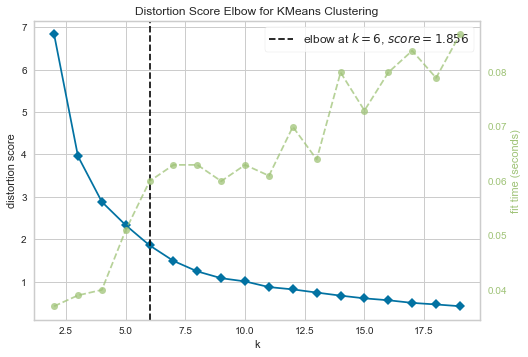

6

In [14]:
# Elbow method is used to find the optimum number of clusters for k-means.

kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(X)
elbow.show()

elbow.elbow_value_

In [15]:
kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(X)
sets = kmeans.labels_

In [16]:
dataset["cluster_no"] = sets

dataset["cluster_no"] = dataset["cluster_no"] + 1


In [17]:
dataset.head()

,place_name,city,town,address,name_rg,price_check_rg,rank_rg,rating_rg,price_rg,address_rg,features_rg,website_rg,instagram_rg,cuisine_rg,yelp_rg,trip_rg,google_rate,google_total,checkpoint,rating_rg_split,yelp_rate,yelp_total,zomato_rate,zomato_total,foursquare_rate,foursquare_total,trip_rate,trip_total,facebook_rate,facebook_total,total_score,google_score,total_score_scaled,google_score_scaled,cluster_no
0,11 Kadıköy,İstanbul,Kadıköy,CAFERAĞA MAH ARAYICI BAŞI SOK NO 11 A-1 KADIKO...,11 Kadıköy,No-Info,#221 of 72430 restaurants in Istanbul,Ratings of 11 Kadıköy\nZomato\n4.6 / 5\n1097\n...,$$$$ Price range per person TRY 170 - TRY 410,"Address\nKadıköy\nArayıcıbaşı Sk. No:11, Istan...",Features\nСredit cards accepted\nOutdoor seati...,No-Info,@11kadikoy,Cocktail bars,No-Info,No-Info,4.4,437,True,Ratings of 11 Kadıköy Zomato 4.6 / 5 1097 Four...,0.0,0.0,4.6,1097.0,8.8,63.0,0.0,0.0,0.0,0.0,5323.40,1922.8,0.115786,0.077477,1
1,3g pub,İzmir,Konak,CUMHURİYET BULVARI NO:18 KONAK IZMIR,3G Cafe,Expensive (average price TRY 410 - TRY 830),#1732 of 12479 cafes in Izmir,Ratings of 3G Cafe\nYelp\nNot rated yet\nFours...,$$$$ Price range per person TRY 410 - TRY 830,Address\nÇankaya\nKonak Mahallesi İzmirlioğlu ...,Features\nСredit cards accepted\nOutdoor seati...,No-Info,No-Info,No-Info,no_rating,No-Info,3.5,21,True,Ratings of 3G Cafe Yelp Not rated yet Foursqua...,0.0,0.0,0.0,0.0,6.7,59.0,0.0,0.0,0.0,0.0,197.65,73.5,0.004299,0.002962,2
2,45 Bar Kadikoy,İstanbul,Kadıköy,İSTANBUL KADIKÖY KADIKOY ISTANBUL,45 Bar Kadikoy,No-Info,#1309 of 11620 pubs & bars in Istanbul,Ratings of 45 Bar Kadikoy\nZomato\n2.4 / 5\n83...,$$$$ Price range per person TRY 170 - TRY 410,"Address\nKadıköy\nMiralay Nazım Sk. No:19/A, I...",Features\nСredit cards accepted\nWi-Fi\nBookin...,Website\n45likkadikoy.com,@45likcomtr,No-Info,No-Info,No-Info,3.7,565,True,Ratings of 45 Bar Kadikoy Zomato 2.4 / 5 83 Fo...,0.0,0.0,2.4,83.0,5.5,364.0,0.0,0.0,1.0,1.0,1201.20,2090.5,0.026127,0.084234,2
3,6:45 Losers Club,İzmir,Konak,1482 SOKAK NO:10 KONAK IZMIR,6:45 Losers Club,Moderate (average price TRY 170 - TRY 410),#47 of 599 clubs in Izmir,Ratings of 6:45 Losers Club\nGoogle\n955,$$$$ Price range per person TRY 170 - TRY 410,"Address\nÇankaya\nMuzaffer İzgü Sk. No:10, Izm...",Features\nNo delivery\nOutdoor seating\nNo tak...,No-Info,No-Info,No-Info,No-Info,No-Info,4.1,1011,True,Ratings of 6:45 Losers Club Google 955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,4145.1,0.000000,0.167021,1
4,Adabeyi Balık Restoran,İzmir,Konak,ATATÜRK Cd.AKDENİZ Mh. No:19/d,Adabeyi Balık Restoran,Expensive (average price TRY 410 - TRY 830),#320 of 18291 restaurants in Izmir,Ratings of Adabeyi Balık Restoran\nYelp\n5\nZo...,$$$$ Price range per person TRY 410 - TRY 830,Address\nÇankaya\nKonak Atatürk Cad. Konak Pie...,Features\nСredit cards accepted\nOutdoor seati...,No-Info,No-Info,"Seafood, Turkish",yelp_block stars5,fill rate4_5,4.2,819,True,Ratings of Adabeyi Balık Restoran Yelp 5 Zomat...,5.0,5.0,3.8,48.0,8.1,899.0,4.5,127.0,4.2,539.0,6683.65,3439.8,0.145372,0.138602,1


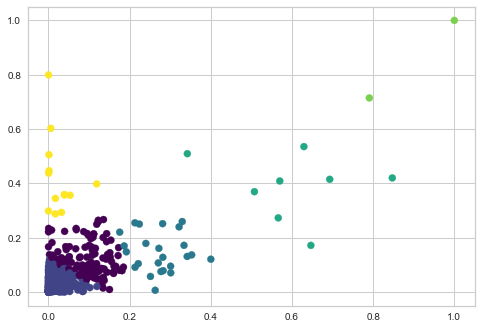

In [18]:
# Below is a visual representation of the clusters. As can be seen, the values are concentrated in the left, i.e the 
# majority has low scores.

plt.scatter(X.iloc[:, 0],
            X.iloc[:, 1],
            c=sets,
            s=50,
            cmap="viridis")
plt.show()

In [19]:
# Number of places in each cluster:

dataset.groupby("cluster_no").agg({"cluster_no": "count"})

,cluster_no
cluster_no,
1,118
2,409
3,24
4,8
5,2
6,13


In [20]:
# The clusters are not labeled in ascending order with the scores, so first google scores are taken as basis and their mean
# value for each cluster is calculated. Then the places are segmented.

dataset.groupby("cluster_no").agg({"google_score_scaled":"mean"})

,google_score_scaled
cluster_no,
1,0.124400
2,0.031867
3,0.146785
4,0.388275
5,0.857385
6,0.422428


In [22]:
dataset.loc[dataset["cluster_no"]==1, "success_level"] = "Low"
dataset.loc[dataset["cluster_no"]==2, "success_level"] = "Too low"
dataset.loc[dataset["cluster_no"]==3, "success_level"] = "Medium"
dataset.loc[dataset["cluster_no"]==4, "success_level"] = "High"
dataset.loc[dataset["cluster_no"]==5, "success_level"] = "Highest"
dataset.loc[dataset["cluster_no"]==6, "success_level"] = "Very high"

In [23]:
dataset[dataset["success_level"] == "Highest"]

,place_name,city,town,address,name_rg,price_check_rg,rank_rg,rating_rg,price_rg,address_rg,features_rg,website_rg,instagram_rg,cuisine_rg,yelp_rg,trip_rg,google_rate,google_total,checkpoint,rating_rg_split,yelp_rate,yelp_total,zomato_rate,zomato_total,foursquare_rate,foursquare_total,trip_rate,trip_total,facebook_rate,facebook_total,total_score,google_score,total_score_scaled,google_score_scaled,cluster_no,success_level
367,Tavacı Recep Usta Alsancak - İzmir,İzmir,Konak,ATATÜRK CAD.NO:364 KONAK IZMIR,Tavacı Recep Usta Alsancak - İzmir,No-Info,#134 of 18291 restaurants in Izmir,Ratings of Tavacı Recep Usta Alsancak - İzmir\...,$$$$ Price range per person TRY 410 - TRY 830,"Address\nAtatürk Cd. No:364, Izmir, İzmir, Turkey",Features\nСredit cards accepted\nOutdoor seati...,Website\ntavacirecepusta.com,@trecepusta,"Turkish, Steakhouses",yelp_block stars4_5,fill rate4,4.2,5909,True,Ratings of Tavacı Recep Usta Alsancak - İzmir ...,4.5,15.0,4.1,269.0,8.9,8724.0,4.0,1496.0,0.0,0.0,45976.2,24817.8,1.000000,1.000000,5,Highest
396,Viktor Levi Şarap Evi,İstanbul,Kadıköy,Caferağa Mah. Damacı Sok. No.4/A Kadıköy/İSTANBUL,Viktor Levi Şarap Evi,Moderate (average price TRY 250 - TRY 330),#1783 of 72430 restaurants in Istanbul,Ratings of Viktor Levi Şarap Evi\nYelp\n24\nZo...,$$$$ Price range per person TRY 250 - TRY 330,"Address\nKadıköy\nCaferağa Mh Moda Cd. &, Dama...",Features\nСredit cards accepted\nOutdoor seati...,Website\nviktorlevimoda.com,@viktorlevimoda,"Wine bars, Fast food, Seafood, Vegetarian options",yelp_block stars3_5,fill rate4,4.5,3942,True,Ratings of Viktor Levi Şarap Evi Yelp 24 Zomat...,3.5,24.0,4.4,1527.0,9.0,6327.0,4.0,265.0,4.0,4.0,36350.3,17739.0,0.790633,0.714769,5,Highest
